# Build Bayesian Neural Networks in Pytorch

## Tensors in PyTorch

In [1]:
import torch
import numpy as np

Check if a GPU is available

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1050
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


We can convert a numpy array in a Pytorch tensor

In [3]:
print("This is a numpy array:")
a = np.array([1, 2, 3], dtype = np.float64)
print(a)
print()

print("This is a Pytorch tensor:")
a_tensor = torch.tensor(a)
print(a_tensor)
print()

print("This is a Pytorch tensor with a different type:")
a_tensor_int = torch.tensor(a, dtype = torch.int32)
print(a_tensor_int)
print()

print("This is a Pytorch tensor on GPU:")
a_tensor_cuda1 = a_tensor.cuda() # we can switch to cpu again with .cpu()
print(a_tensor_cuda1)
print()
del a_tensor_cuda1

print("This is also a Pytorch tensor on GPU:")
a_tensor_cuda2 = torch.tensor(a, device = device)
print(a_tensor_cuda2)
print()
del a_tensor_cuda2

print("This is a Pytorch tensor with gradient:")
a_tensor_grad = torch.tensor(a, requires_grad = True)
print(a_tensor_grad)
print()

print("This is also a Pytorch tensor with gradient:")
a_tensor_grad = torch.nn.Parameter(torch.tensor(a))
print(a_tensor_grad)
print()

print("This is a Pytorch tensor without gradient:")
a_tensor_grad_without = a_tensor_grad.data
print(a_tensor_grad_without)
print()

print("This is a numpy array:")
a_tensor_grad_numpy = a_tensor_grad.data.numpy()
print(a_tensor_grad_numpy)
print()

This is a numpy array:
[1. 2. 3.]

This is a Pytorch tensor:
tensor([1., 2., 3.], dtype=torch.float64)

This is a Pytorch tensor with a different type:
tensor([1, 2, 3], dtype=torch.int32)

This is a Pytorch tensor on GPU:
tensor([1., 2., 3.], device='cuda:0', dtype=torch.float64)

This is also a Pytorch tensor on GPU:
tensor([1., 2., 3.], device='cuda:0', dtype=torch.float64)

This is a Pytorch tensor with gradient:
tensor([1., 2., 3.], dtype=torch.float64, requires_grad=True)

This is also a Pytorch tensor with gradient:
Parameter containing:
tensor([1., 2., 3.], dtype=torch.float64, requires_grad=True)

This is a Pytorch tensor without gradient:
tensor([1., 2., 3.], dtype=torch.float64)

This is a numpy array:
[1. 2. 3.]



## Load MNIST dataset

In [4]:
import gzip

We can download MNIST training and test set from: http://yann.lecun.com/exdb/mnist/

In [5]:
def train_load_mnist():
    
    """Load MNIST data from `path`"""
    labels_path = 'train-labels-idx1-ubyte.gz'
    images_path = 'train-images-idx3-ubyte.gz'
        
    with gzip.open(labels_path, 'rb') as lbpath:
        # skip the first byte
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        # skip the first and the second byte
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, dtype=np.uint8).reshape( len(labels), 784)
 
    return images, labels


def train_mnist_preprocessing(images, labels):
    
    x = np.float32(images)/126
    y = np.int32(labels)

    return x, y

In [6]:
images, labels = train_load_mnist()
tr_x, tr_y = train_mnist_preprocessing(images, labels)

 Check the shapes of the images and labels, we expect to have 60000 images 28X28 and 60000 labels

In [7]:
print("The shapes are: "+ str(np.shape(tr_x))+ " and "+ str(np.shape(tr_y)))

The shapes are: (60000, 784) and (60000,)


Check that a label is associated to the right image

In [8]:
import matplotlib.pyplot as plt

The image: 


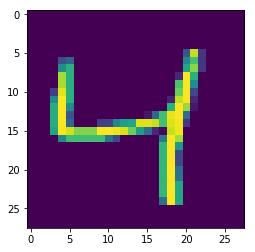

is a 4


In [9]:
print("The image: ")
image = np.asarray(tr_x[2,:]).reshape( 28, 28 )
label = tr_y[2]
plt.imshow(image)
plt.show()

print("is a "+ str(label) )

Now that our training set is ready we can start building the neural networks. We will consider a very simple architecture composed by **2 layers of 400 rectified linear units for both the neural network and the Bayesian neural network**. Remark that the training set is given by numpy arrays, we will need tensors at some point.

Similarly for the test set...

In [10]:
def test_load_mnist():
    
    """Load MNIST data from `path`"""
    labels_path = 't10k-labels-idx1-ubyte.gz'
    images_path = 't10k-images-idx3-ubyte.gz'
        
    with gzip.open(labels_path, 'rb') as lbpath:
        # skip the first byte
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        # skip the first and the second byte
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, dtype=np.uint8).reshape( len(labels), 784)
 
    return images, labels


def test_mnist_preprocessing(images, labels):
    
    x = np.float32(images)/126
    y = np.int32(labels)

    return x, y

In [11]:
images_test, labels_test = test_load_mnist()
te_x, te_y = train_mnist_preprocessing(images_test, labels_test)

## Neural network

In [12]:
import torch
import torch.nn as nn # these are Python classes
import torch.nn.functional as F # these are Python functions

### A simple way...

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__() # Avoid calling nn.Module to call Net
        
        # this builds the first layer
        self.W1 = nn.Linear(784, 400)  # WX + b
        # this builds the second layer
        self.W2 = nn.Linear(400, 400)
        # this builds the output layer
        self.W3 = nn.Linear(400, 10)

        
    def forward(self, x):

        h = F.relu(self.W1(x))
        h = F.relu(self.W2(h))
        h = self.W3(h)
        
        return h

What is in Net()?

In [14]:
net = Net()
print(net)

Net(
  (W1): Linear(in_features=784, out_features=400, bias=True)
  (W2): Linear(in_features=400, out_features=400, bias=True)
  (W3): Linear(in_features=400, out_features=10, bias=True)
)


Can we apply Net() to an array extracted from our training?

In [15]:
image = tr_x[2,:]
output = net(image)
print(output.data.numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

Can we apply Net() to a tensor extracted from our training?

In [16]:
image = torch.tensor(tr_x[2,:])
output = net(image)
print(output.data.numpy())

[-1.75162740e-02  3.92843261e-02 -6.74826652e-02  4.51564454e-02
  1.00881025e-01 -8.65701586e-05 -9.42470878e-03 -2.37726830e-02
 -1.15810968e-02 -4.34552208e-02]


#### Training

In [17]:
import time

Let us train our Net().
1. Create a DataLoader: this will automatically shuffle before any epoch and prepare the minibatches.
2. Choose the loss function and optimizer: in our case we will use a Cross Entropy Loss and stochastic gradient descent.
3. Choose the number of epochs and train.

1. Create a DataLoader.

In [18]:
from torch.utils import data

# Choose the size of the minibatch
batch_size=128

# Create a dataset (use 50000 for training and 10000 for validation)
tr_x_tensor = torch.tensor(tr_x[:50000,:])
tr_y_tensor = torch.tensor(tr_y[:50000], dtype = torch.long)
train = data.TensorDataset(tr_x_tensor, tr_y_tensor)
    
# Set up the DataLoader
train_loader = data.DataLoader(train, batch_size, shuffle=True, num_workers=4)

Check the minibatch shape and what is contained in it.

images.shape: torch.Size([128, 784])


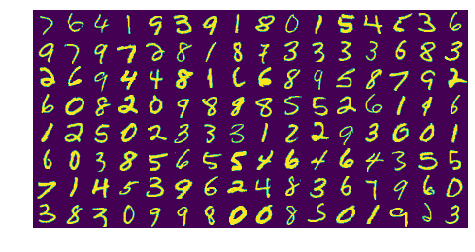

In [19]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,4))
    plt.axis('off')
    images_column = images.data.numpy().reshape(128*28, 28)
    
    t= 1
    image_stack = images_column[28*8*(t-1):28*8*(t),:]
    while t< 16:
        t+=1
        image_stack  = np.hstack((image_stack, images_column[28*8*(t-1):28*8*(t),:]))
    plt.imshow( image_stack)
    break

2. Choose the loss function and optimizer.

In [20]:
# Cross entropy loss
loss_function = F.cross_entropy

# SGD: we have to plug-in the parameters we want to learn
optimizer = torch.optim.SGD(net.parameters(), lr = 10**(-3))

3. Choose the number of epochs and train.

In [21]:
epochs = 20
loss_history = torch.tensor(np.zeros(epochs+1))

images_val = torch.tensor(tr_x[50000:,:])
labels_val = torch.tensor(tr_y[50000:], dtype = torch.long)

start = time.time() 
for epoch in range(epochs):
        print("Epoch: ", epoch)
        output_val = net(images_val)
        loss_val = loss_function(output_val, labels_val)
        
        loss_history[epoch] = loss_val
        print("The loss before starting this epoch is ", np.round(loss_val.data.numpy(), 5))
        
        # Training Phase 
        for images_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            
            output = net(images_batch)
            loss = loss_function(output, labels_batch)
            loss.backward()
            
            optimizer.step()
            
output_val = net(images_val)
loss_val = loss_function(output_val, labels_val)

loss_history[epoch+1] = loss_val
print("###########################################")
print("The training took ", np.round(time.time() - start, 2))

Epoch:  0
The loss before starting this epoch is  2.30511
Epoch:  1
The loss before starting this epoch is  2.24164
Epoch:  2
The loss before starting this epoch is  2.16525
Epoch:  3
The loss before starting this epoch is  2.05788
Epoch:  4
The loss before starting this epoch is  1.90122
Epoch:  5
The loss before starting this epoch is  1.6863
Epoch:  6
The loss before starting this epoch is  1.43301
Epoch:  7
The loss before starting this epoch is  1.19149
Epoch:  8
The loss before starting this epoch is  0.99821
Epoch:  9
The loss before starting this epoch is  0.85605
Epoch:  10
The loss before starting this epoch is  0.7526
Epoch:  11
The loss before starting this epoch is  0.67599
Epoch:  12
The loss before starting this epoch is  0.61746
Epoch:  13
The loss before starting this epoch is  0.57189
Epoch:  14
The loss before starting this epoch is  0.53539
Epoch:  15
The loss before starting this epoch is  0.50612
Epoch:  16
The loss before starting this epoch is  0.48155
Epoch:  1

Let us check the loss during training

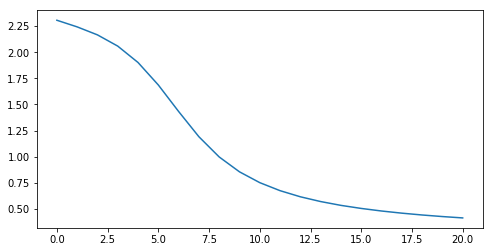

In [22]:
plt.figure(figsize=(8,4))
plt.plot(loss_history.data.numpy())
plt.show()

Let us measure the accuracy

In [23]:
# Prepare the test set
images_te = torch.tensor(te_x)
labels_te = te_y # do not need a tensor here

# Compute a distribution over the test labels
output           = net( images_te )
output_softmax   = F.softmax(output, dim=1)

# Predict the test label with the one associated to the max probability
labels          = np.array( range(0, 10) )
max_label_index = np.argmax( output_softmax.data.numpy(), 1 )
label_predicted = labels[ max_label_index ]

# Mesure the accuracy as the proportion of exact classifications
te_performance = np.sum(labels_te == label_predicted)/len(te_y)
print("The accuracy of this neural network is: "+ str(te_performance))

The accuracy of this neural network is: 0.8895


#### Training on GPU

In [24]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [25]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
# Choose the size of the minibatch
batch_size=128

# Data loader on GPU
train_gpu = DeviceDataLoader(train_loader, device)

In [27]:
# Network to GPU
net_gpu = Net()
net_gpu = to_device(net_gpu, device)

In [28]:
# Cross entropy loss
loss_function = F.cross_entropy

# SGD: we have to plug-in the parameters we want to learn
optimizer = torch.optim.SGD(net_gpu.parameters(), lr = 10**(-3))

In [29]:
epochs = 20
loss_history = torch.tensor(np.zeros(epochs+1), device = device)

images_val = torch.tensor(tr_x[50000:,:], device = device)
labels_val = torch.tensor(tr_y[50000:], dtype = torch.long, device = device)

start = time.time() 
for epoch in range(epochs):
    # do not store any gradient when computing the validation score
    with torch.no_grad():
        print("Epoch: ", epoch)
        output_val = net_gpu(images_val)
        loss_val = loss_function(output_val, labels_val)
        
        loss_history[epoch] = loss_val
#         print("The loss before starting this epoch is ", np.round(loss_val.data, 5))
        
    # Training Phase 
    for images_batch, labels_batch in train_gpu:
        optimizer.zero_grad()

        output = net_gpu(images_batch)
        loss = loss_function(output, labels_batch)
        loss.backward()

        optimizer.step()

with torch.no_grad():
    output_val = net_gpu(images_val)
    loss_val = loss_function(output_val, labels_val)

    loss_history[epoch+1] = loss_val
print("###########################################")
print("The training took ", np.round(time.time() - start, 2))

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
###########################################
The training took  40.48


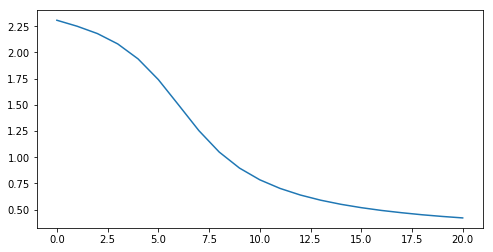

In [30]:
plt.figure(figsize=(8,4))
plt.plot(loss_history.cpu().data.numpy())
plt.show()

In [31]:
# Prepare the test set
images_te_cuda = torch.tensor(te_x, device = device)
labels_te = te_y # do not need a tensor here

# Compute a distribution over the test labels
output           = net_gpu( images_te_cuda )
output_softmax   = F.softmax(output.cpu(), dim=1)

# Predict the test label with the one associated to the max probability
labels          = np.array( range(0, 10) )
max_label_index = np.argmax( output_softmax.data.numpy(), 1 )
label_predicted = labels[ max_label_index ]

# Mesure the accuracy as the proportion of exact classifications
te_performance = np.sum(labels_te == label_predicted)/len(te_y)
print("The accuracy of this neural network is: "+ str(te_performance))

The accuracy of this neural network is: 0.8879


### A complex way...

We can define our personal Linear function, it is going to be useful when we switch to a Bayesian framework.

In [32]:
class wParameter(nn.Module):

    def __init__(self, in_features, out_features ):
        super().__init__()

        self.in_features  = in_features
        self.out_features = out_features
        
        weight_numpy = np.random.uniform(-np.sqrt(1/in_features), +np.sqrt(1/in_features), (out_features, in_features))
        bias_numpy   = np.random.uniform(-np.sqrt(1/in_features), +np.sqrt(1/in_features), (out_features             ))
        
        weight_tensor = torch.tensor(weight_numpy, dtype = torch.float32)
        bias_tensor   = torch.tensor(bias_numpy,   dtype = torch.float32)  

        self.weight = nn.Parameter(weight_tensor)
        self.bias   = nn.Parameter(bias_tensor)

class PersonalLinearLayer(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()

        self.in_features  = in_features
        self.out_features = out_features

        self.W  = wParameter(in_features, out_features)   


    def forward(self, input):

        W_weight = self.W.weight
        W_bias   = self.W.bias

        return F.linear(input, W_weight, W_bias)

In [33]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__() # Avoid calling nn.Module to call Net
        
        # this builds the first layer
        self.W1 = PersonalLinearLayer(784, 400)  
        # this builds the second layer
        self.W2 = PersonalLinearLayer(400, 400)
        # this builds the output layer
        self.W3 = PersonalLinearLayer(400, 10)

        
    def forward(self, x):

        h = F.relu(self.W1(x))
        h = F.relu(self.W2(h))
        h = self.W3(h)
        
        return h

#### Training

In [34]:
net = Net()

In [35]:
# Cross entropy loss
loss_function = F.cross_entropy

# SGD: we have to plug-in the parameters we want to learn
optimizer = torch.optim.SGD(net.parameters(), lr = 10**(-3))

In [36]:
epochs = 20
loss_history = torch.tensor(np.zeros(epochs+1))

images_val = torch.tensor(tr_x[50000:,:])
labels_val = torch.tensor(tr_y[50000:], dtype = torch.long)

start = time.time() 
for epoch in range(epochs):
        print("Epoch: ", epoch)
        output_val = net(images_val)
        loss_val = loss_function(output_val, labels_val)
        
        loss_history[epoch] = loss_val
        print("The loss before starting this epoch is ", np.round(loss_val.data.numpy(), 5))
        
        # Training Phase 
        for images_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            
            output = net(images_batch)
            loss = loss_function(output, labels_batch)
            loss.backward()
            
            optimizer.step()
            
output_val = net(images_val)
loss_val = loss_function(output_val, labels_val)

loss_history[epoch+1] = loss_val
print("###########################################")
print("The training took ", np.round(time.time() - start, 2))

Epoch:  0
The loss before starting this epoch is  2.29298
Epoch:  1
The loss before starting this epoch is  2.23156
Epoch:  2
The loss before starting this epoch is  2.15458
Epoch:  3
The loss before starting this epoch is  2.04614
Epoch:  4
The loss before starting this epoch is  1.89231
Epoch:  5
The loss before starting this epoch is  1.68742
Epoch:  6
The loss before starting this epoch is  1.44754
Epoch:  7
The loss before starting this epoch is  1.21384
Epoch:  8
The loss before starting this epoch is  1.02154
Epoch:  9
The loss before starting this epoch is  0.87717
Epoch:  10
The loss before starting this epoch is  0.77069
Epoch:  11
The loss before starting this epoch is  0.69117
Epoch:  12
The loss before starting this epoch is  0.63051
Epoch:  13
The loss before starting this epoch is  0.58328
Epoch:  14
The loss before starting this epoch is  0.54538
Epoch:  15
The loss before starting this epoch is  0.51457
Epoch:  16
The loss before starting this epoch is  0.48919
Epoch: 

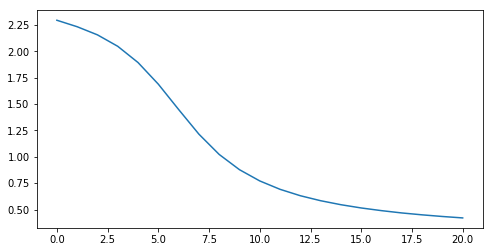

In [37]:
plt.figure(figsize=(8,4))
plt.plot(loss_history.data.numpy())
plt.show()

In [38]:
# Prepare the test set
images_te = torch.tensor(te_x)
labels_te = te_y # do not need a tensor here

# Compute a distribution over the test labels
output           = net( images_te )
output_softmax   = F.softmax(output, dim=1)

# Predict the test label with the one associated to the max probability
labels          = np.array( range(0, 10) )
max_label_index = np.argmax( output_softmax.data.numpy(), 1 )
label_predicted = labels[ max_label_index ]

# Mesure the accuracy as the proportion of exact classifications
te_performance = np.sum(labels_te == label_predicted)/len(te_y)
print("The accuracy of this neural network is: "+ str(te_performance))

The accuracy of this neural network is: 0.8866


#### Training on GPU

In [39]:
# Choose the size of the minibatch
batch_size=128

# Data loader on GPU
train_gpu = DeviceDataLoader(train_loader, device)

In [40]:
# Network to GPU
net_gpu = Net()
net_gpu = to_device(net_gpu, device)

In [41]:
# Cross entropy loss
loss_function = F.cross_entropy

# SGD: we have to plug-in the parameters we want to learn
optimizer = torch.optim.SGD(net_gpu.parameters(), lr = 10**(-3))

In [42]:
epochs = 20
loss_history = torch.tensor(np.zeros(epochs+1), device = device)

images_val = torch.tensor(tr_x[50000:,:], device = device)
labels_val = torch.tensor(tr_y[50000:], dtype = torch.long, device = device)

start = time.time() 
for epoch in range(epochs):
    with torch.no_grad():
        print("Epoch: ", epoch)
        output_val = net_gpu(images_val)
        loss_val = loss_function(output_val, labels_val)
        
        loss_history[epoch] = loss_val
#         print("The loss before starting this epoch is ", np.round(loss_val.data, 5))
        
    # Training Phase 
    for images_batch, labels_batch in train_gpu:
        optimizer.zero_grad()

        output = net_gpu(images_batch)
        loss = loss_function(output, labels_batch)
        loss.backward()

        optimizer.step()

with torch.no_grad():
    output_val = net_gpu(images_val)
    loss_val = loss_function(output_val, labels_val)

    loss_history[epoch+1] = loss_val
print("###########################################")
print("The training took ", np.round(time.time() - start, 2))

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
###########################################
The training took  41.08


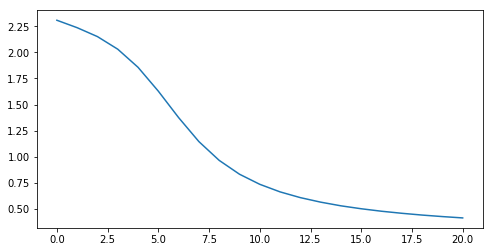

In [43]:
plt.figure(figsize=(8,4))
plt.plot(loss_history.cpu().data.numpy())
plt.show()

In [44]:
# Prepare the test set
images_te_cuda = torch.tensor(te_x, device = device)
labels_te = te_y # do not need a tensor here

# Compute a distribution over the test labels
output           = net_gpu( images_te_cuda )
output_softmax   = F.softmax(output.cpu(), dim=1)

# Predict the test label with the one associated to the max probability
labels          = np.array( range(0, 10) )
max_label_index = np.argmax( output_softmax.data.numpy(), 1 )
label_predicted = labels[ max_label_index ]

# Mesure the accuracy as the proportion of exact classifications
te_performance = np.sum(labels_te == label_predicted)/len(te_y)
print("The accuracy of this neural network is: "+ str(te_performance))

The accuracy of this neural network is: 0.8876


## Bayesian neural network

A Bayesian neural network has a distribution over the weights instead of point estimates. For more details about the implemented method, we refer to the paper "Weight Uncertainty in Neural Network" by Blundell et al. (https://arxiv.org/pdf/1505.05424.pdf).

In [45]:
from IPython.display import IFrame
IFrame("BayesianNN.pdf", width=1000, height=600)

We cannot compute the posterior over the weights of the neural network so we approximate it with Variational Bayes. Precisely, we approximate the posterior over the weights $p(W|\mathcal{D})$ with independent Gaussian distributions (mean field approximation), i.e. $p(W|\mathcal{D})$ is approximated with $q(W|\theta)$ with $\theta = (\mu^{(i)}, \rho^{(i)})_{i=1,\dots,\text{card}(W)}$ where:

$$
q(W|\theta) = \prod_{i=1}^{\text{card}(W)} \mathcal{N}(w^{(i)}|\mu^{(i)}, (\sigma^{(i)})^2)
$$

with $\sigma^{(i)}=\log(1+\exp(\rho^{(i)}))$.



Hence having a function for computing the a Gaussian density is going to be useful...

In [46]:
def Gaussian_density(w, mu, sigma):
    
    return (1/(np.sqrt(2*np.pi)*sigma))*torch.exp(-(w - mu)*(w - mu)/(2*sigma*sigma))

#### Implement a Bayesian neural network

As we have seen before the key point in implementi neural networks is to implement the linear layer. In Bayesian neural network with mean-field approximation we want the linear layer to have:
1. the right dimension (input and output feautures);
2. weights that are Gaussian random variables with some learnable parameters ($\mu$ and $\rho$);
3. a forward method that apply the linear transformation after applying the weights.

BONUS:
4. A way to compute the log-likelihood over the weights.
5. A way to compute the log-prior over the weights.

**First step** Implement some classes for $\mu$ and $\rho$ and a way to combine them in a Gaussian distribution.

In [47]:
class muParameter(nn.Module):

    def __init__(self, in_features, out_features ):
        super().__init__()

        self.in_features  = in_features
        self.out_features = out_features
        

        weight_numpy = np.random.uniform(-np.sqrt(1/in_features), +np.sqrt(1/in_features), (out_features, in_features))
        bias_numpy   = np.random.uniform(-np.sqrt(1/in_features), +np.sqrt(1/in_features), (out_features             ))
        
        weight_tensor = torch.tensor(weight_numpy, dtype = torch.float32)
        bias_tensor   = torch.tensor(bias_numpy,   dtype = torch.float32)  

        self.weight = nn.Parameter(weight_tensor)
        self.bias   = nn.Parameter(bias_tensor)
        
        
class rhoParameter(nn.Module):

    def __init__(self, in_features, out_features ):
        super().__init__()

        self.in_features  = in_features
        self.out_features = out_features
        

        weight_numpy = np.random.uniform(-5, -4, (out_features, in_features))
        bias_numpy   = np.random.uniform(-5, -4, (out_features             ))
        
        weight_tensor = torch.tensor(weight_numpy, dtype = torch.float32)
        bias_tensor   = torch.tensor(bias_numpy,   dtype = torch.float32)  

        self.weight = nn.Parameter(weight_tensor)
        self.bias   = nn.Parameter(bias_tensor)
        
# a Gaussian random variable for the weights where we can automatically compute the log-likelihood    
class Gaussian(object):
    
    def __init__(self, mu, rho, device = torch.device("cpu")):
        super().__init__()
        self.mu = mu
        self.rho = rho
        
        mean = torch.tensor(0, dtype = torch.float32).to(device)
        std  = torch.tensor(1, dtype = torch.float32).to(device)

        self.normal    = torch.distributions.Normal(mean, std)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        
        epsilon = self.normal.sample(self.rho.size())
        
        return self.mu + self.sigma * epsilon
    
    def log_likelihood(self, w):
        
        return torch.sum(torch.log(Gaussian_density(w, self.mu, self.sigma)))

**Second step** Choose the prior form.

As for Blundell et al., we choose a prior that is a mixture of Gaussians per each weight:

$$
p(W) = \prod_{i=1}^{\text{card}(W)} \pi\mathcal{N}(w^{(i)}|0, \sigma_1^2) + (1-\pi)\mathcal{N}(w^{(i)}|0, \sigma_2^2).
$$


**Third step** Combine the above classes in the Bayesian equivalent of *nn.Linear*.

In [48]:
# This method model the weigths of the layer as Gaussians and it automatically compute the log-likelihood and the prior score.
class LinearBayesianGaussian(nn.Module):
    # the values of pi, sigma_1 and sigma_2 are extracted from a grid in Blundell et al.
    def __init__(self, in_features, out_features, device = torch.device("cpu"), pi = 0.5, sigma_1 = np.exp(-1), sigma_2 = np.exp(-6)):
        super().__init__()

        self.in_features  = in_features
        self.out_features = out_features

        self.mu  = muParameter(in_features,  out_features)
        self.rho = rhoParameter(in_features, out_features)
        
        # the weights are random
        self.weight_distribution = Gaussian(self.mu.weight, self.rho.weight, device)
        self.bias_distribution   = Gaussian(self.mu.bias  , self.rho.bias, device)     
        
        # prior parameters
        self.pi = pi
        self.sigma_1 = sigma_1
        self.sigma_2 = sigma_2


    def forward(self, input):
        
        # sample weights
        self.weight = self.weight_distribution.sample()
        self.bias   = self.bias_distribution.sample()
        
        # apply the linear transformation
        return F.linear(input, self.weight, self.bias)
    
    # these can be called only after a first call of the forward step
    # compute the log-likelihoood
    @property
    def log_likelihood(self):

        return self.weight_distribution.log_likelihood(self.weight) + self.bias_distribution.log_likelihood(self.bias)
    
    # compute the log prior
    @property
    def log_prior(self):
        gaussian1_weight = Gaussian_density(self.weight, 0*self.weight, self.sigma_1)
        gaussian2_weight = Gaussian_density(self.weight, 0*self.weight, self.sigma_2)
        
        gaussian1_bias = Gaussian_density(self.bias, 0*self.bias, self.sigma_1)
        gaussian2_bias = Gaussian_density(self.bias, 0*self.bias, self.sigma_2)
        
        gaussian_mixture_weight = torch.sum(torch.log(self.pi*gaussian1_weight + (1-self.pi)*gaussian2_weight))
        gaussian_mixture_bias   = torch.sum(torch.log(self.pi*gaussian1_bias   + (1-self.pi)*gaussian2_bias))

        return gaussian_mixture_weight + gaussian_mixture_bias

**Fourth step** Build a Bayesian neural network by stacking together the Bayesian Linear functions.

In [49]:
class BayesianNet(nn.Module):

    def __init__(self, device = torch.device("cpu"), pi = 0.5, sigma_1 = np.exp(-1), sigma_2 = np.exp(-6)):
        super(BayesianNet, self).__init__() # Avoid calling nn.Module to call Net
        
        # this builds the first layer
        self.W1 = LinearBayesianGaussian(784, 400, device, pi , sigma_1, sigma_2)  
        # this builds the second layer
        self.W2 = LinearBayesianGaussian(400, 400, device, pi , sigma_1, sigma_2)
        # this builds the output layer
        self.W3 = LinearBayesianGaussian(400, 10, device, pi, sigma_1, sigma_2)

        
    def forward(self, x):

        h = F.relu(self.W1(x))
        h = F.relu(self.W2(h))
        h = self.W3(h)
        
        return h
    
    # these can be called only after a first call of the forward step
    @property
    def log_likelihood(self):
        
        return self.W1.log_likelihood + self.W2.log_likelihood + self.W3.log_likelihood
    
    @property
    def log_prior(self):
        
        return self.W1.log_prior + self.W2.log_prior + self.W3.log_prior

#### Training

We want to minimize:

$$
\mathbf{KL}(q(W|\theta)||p(W|\mathcal{D}))=\mathbf{KL}(q(W|\theta)||p(W)) - \mathbb{E}_{q(W|\theta)}[\log(p(\mathcal{D}|W))]
$$

with $\mathbf{KL}(q(W|\theta)||p(W))$ the expected difference between the log-likelihood and the prior score, and $-\log(p(\mathcal{D}|W))$ is the cross-entropy loss. 

The above is suitable to minibatches optimization. As suggested by Blundell et al. we actually minimize:

$$
\frac{1}{M} \mathbf{KL}(q(W|\theta)||p(W)) - \mathbb{E}_{q(W|\theta)}[\log(p(\mathcal{D}^{(\text{batch})}|W))]
$$

with $M$ number of minibatches. 

In [50]:
bayesnet = BayesianNet()

In [51]:
# Cross entropy loss
loss_function = F.cross_entropy

# SGD: we have to plug-in the parameters we want to learn
optimizer = torch.optim.SGD(bayesnet.parameters(), lr = 10**(-3))

In [53]:
# number of minibatches
M = int(round(50000/batch_size, 0))

epochs = 5
loss_history = torch.tensor(np.zeros(epochs+1))

images_val = torch.tensor(tr_x[50000:,:])
labels_val = torch.tensor(tr_y[50000:], dtype = torch.long)

start = time.time() 
for epoch in range(epochs):
        print("Epoch: ", epoch)
        output_val = bayesnet(images_val)
        loss_val = loss_function(output_val, labels_val, reduction="mean")
        
        loss_history[epoch] = loss_val
        print("The loss before starting this epoch is ", np.round(loss_val.data.numpy(), 5))
        
        # Training Phase 
        for images_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            
            output = bayesnet(images_batch)
            
            loss = loss_function(output, labels_batch, reduction="sum") + (bayesnet.log_likelihood - bayesnet.log_prior)/M
            loss.backward()
            
            optimizer.step()
            
output_val = bayesnet(images_val)
loss_val = loss_function(output_val, labels_val, reduction="mean")

loss_history[epoch] = loss_val
print("###########################################")
print("The training took ", np.round(time.time() - start, 2))

Epoch:  0
The loss before starting this epoch is  2.30755
Epoch:  1
The loss before starting this epoch is  0.29779
Epoch:  2
The loss before starting this epoch is  0.2381
Epoch:  3
The loss before starting this epoch is  0.19372
Epoch:  4
The loss before starting this epoch is  0.179
Epoch:  5
The loss before starting this epoch is  0.16034
Epoch:  6
The loss before starting this epoch is  0.15263
Epoch:  7
The loss before starting this epoch is  0.14699
Epoch:  8
The loss before starting this epoch is  0.12263
Epoch:  9
The loss before starting this epoch is  0.13671
###########################################
The training took  333.45


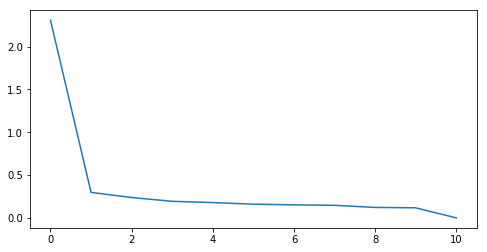

In [54]:
plt.figure(figsize=(8,4))
plt.plot(loss_history.data.numpy())
plt.show()

To measure the accuracy we want to sample from the posterior predictive:

$$
    p(\tilde{\mathcal{D}}|\mathcal{D}) = \int p(\tilde{\mathcal{D}}|W)p(W|\mathcal{D}) dW \approx \mathbb{E}_{q(W|\theta)}[p(\tilde{\mathcal{D}}|W)] \approx \frac{1}{N} \sum_{k=1}^N p(\tilde{\mathcal{D}}|w_k), \quad \text{with } w_k \sim q(W|\theta)
$$

In [55]:
# Prepare the test set
images_te = torch.tensor(te_x)
labels_te = te_y # do not need a tensor here

posterior_pred_sample = 10

output_softmax_posterior_pred = np.zeros(10)

for i in range(10):
    # Compute a distribution over the test labels
    output           = bayesnet( images_te )
    output_softmax_posterior_pred = output_softmax_posterior_pred + F.softmax(output, dim=1).data.numpy()
    
output_softmax_posterior_pred = output_softmax_posterior_pred/posterior_pred_sample

# Predict the test label with the one associated to the max probability
labels          = np.array( range(0, 10) )
max_label_index = np.argmax( output_softmax_posterior_pred, 1 )
label_predicted = labels[ max_label_index ]

# Mesure the accuracy as the proportion of exact classifications
te_performance = np.sum(labels_te == label_predicted)/len(te_y)
    
print("The accuracy of this neural network is: "+ str(te_performance))

The accuracy of this neural network is: 0.9635


#### Training on GPU

In [56]:
# Choose the size of the minibatch
batch_size=128

# Data loader on GPU
train_gpu = DeviceDataLoader(train_loader, device)

In [57]:
# Network to GPU
bayesnet_gpu = BayesianNet(device)
bayesnet_gpu = to_device(bayesnet_gpu, device)

In [58]:
# Cross entropy loss
loss_function = F.cross_entropy

# SGD: we have to plug-in the parameters we want to learn
optimizer = torch.optim.SGD(bayesnet_gpu.parameters(), lr = 10**(-3))

In [59]:
epochs = 20
loss_history = torch.tensor(np.zeros(epochs+1), device = device)

images_val = torch.tensor(tr_x[50000:,:], device = device)
labels_val = torch.tensor(tr_y[50000:], dtype = torch.long, device = device)

start = time.time() 
for epoch in range(epochs):
    with torch.no_grad():
        print("Epoch: ", epoch)
        output_val = bayesnet_gpu(images_val)
        loss_val = loss_function(output_val, labels_val)
        
        loss_history[epoch] = loss_val
#         print("The loss before starting this epoch is ", np.round(loss_val.data, 5))
        
    # Training Phase 
    for images_batch, labels_batch in train_gpu:
        optimizer.zero_grad()

        output = bayesnet_gpu(images_batch)
        loss = loss_function(output, labels_batch, reduction="sum") + (bayesnet_gpu.log_likelihood - bayesnet_gpu.log_prior)/M
        loss.backward()

        optimizer.step()

with torch.no_grad():
    output_val = bayesnet_gpu(images_val)
    loss_val = loss_function(output_val, labels_val)

    loss_history[epoch] = loss_val
print("###########################################")
print("The training took ", np.round(time.time() - start, 2))

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
###########################################
The training took  124.33


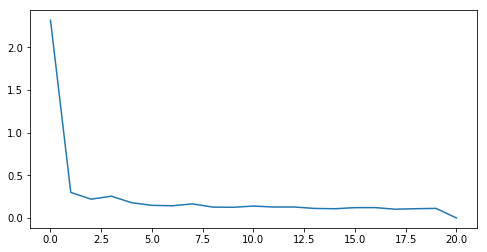

In [60]:
plt.figure(figsize=(8,4))
plt.plot(loss_history.cpu().data.numpy())
plt.show()

In [61]:
# Prepare the test set
images_te_cuda = torch.tensor(te_x, device = device)
labels_te = te_y # do not need a tensor here

posterior_pred_sample = 10

output_softmax_posterior_pred = np.zeros(10)

for i in range(10):
    # Compute a distribution over the test labels
    output           = bayesnet_gpu( images_te_cuda ).cpu()
    output_softmax_posterior_pred = output_softmax_posterior_pred + F.softmax(output, dim=1).data.numpy()
    
output_softmax_posterior_pred = output_softmax_posterior_pred/posterior_pred_sample

# Predict the test label with the one associated to the max probability
labels          = np.array( range(0, 10) )
max_label_index = np.argmax( output_softmax_posterior_pred, 1 )
label_predicted = labels[ max_label_index ]

# Mesure the accuracy as the proportion of exact classifications
te_performance = np.sum(labels_te == label_predicted)/len(te_y)
    
print("The accuracy of this neural network is: "+ str(te_performance))

The accuracy of this neural network is: 0.968


## Clear the GPU memory

Check GPU memory

In [62]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1050
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


Free GPU memory

In [63]:
torch.cuda.empty_cache()

In [64]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1050
Memory Usage:
Allocated: 0.2 GB
Cached:    0.2 GB


In [65]:
del images_val
del labels_val
del bayesnet_gpu
del loss_val
del loss_history
del images_batch
del labels_batch
del train_gpu
del optimizer
del output
del loss
del images_te_cuda
del output_val

torch.cuda.empty_cache()

In [66]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1050
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB
